# Kaggle - Understanding the Amazon from Space

## Data loading

In [2]:
import os
from six import string_types
import numpy as np
import pandas as pd
import seaborn as sns
import skimage
from sklearn.neighbors import KNeighborsClassifier
import cv2
from skimage import io
from tqdm import tqdm
from snorkel.labeling import labeling_function, LabelModel, PandasLFApplier, LFAnalysis, MajorityLabelVoter
import imutils

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
PLANET_KAGGLE_ROOT = os.path.abspath("../data/")
PLANET_KAGGLE_JPEG_DIR = os.path.join(PLANET_KAGGLE_ROOT, 'train-jpg')
PLANET_KAGGLE_LABEL_CSV = os.path.join(PLANET_KAGGLE_ROOT, 'train_v2.csv')
assert os.path.exists(PLANET_KAGGLE_ROOT)
assert os.path.exists(PLANET_KAGGLE_JPEG_DIR)
assert os.path.exists(PLANET_KAGGLE_LABEL_CSV)

In [3]:
labels_df = pd.read_csv(PLANET_KAGGLE_LABEL_CSV)
#labels_df.head()

In [4]:
# Build list with unique labels
label_list = []
for tag_str in labels_df.tags.values:
    labels = tag_str.split(' ')
    for label in labels:
        if label not in label_list:
            label_list.append(label)
#print(label_list)
            
# Preprocess labels
label_map = {l: i for i, l in enumerate(label_list)}

In [5]:
# Add onehot features for every label
for label in label_list:
    labels_df[label] = labels_df['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
# Display head
labels_df.head()

,image_name,tags,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
0,train_0,haze primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1,agriculture clear primary water,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,train_2,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,train_3,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,train_4,agriculture clear habitation primary road,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0


In [6]:
def sample_images(tags, n=None, complement=False):
    """Randomly sample n images with the specified tags."""
    condition = True
    if isinstance(tags, string_types):
        raise ValueError("Pass a list of tags, not a single tag.")
    for tag in tags:
        condition = condition & labels_df[tag] == (not complement)
    if n is not None:
        return labels_df[condition].sample(n)
    else:
        return labels_df[condition]

In [7]:
def load_image(filename):
    '''Look through the directory tree to find the image you specified
    (e.g. train_10.jpg)'''
    for dirname in os.listdir(PLANET_KAGGLE_ROOT):
        path = os.path.abspath(os.path.join(PLANET_KAGGLE_ROOT, dirname, filename))
        if os.path.exists(path):
            #print('Found image {}'.format(path))
            return io.imread(path)
    # If this line reached, image not found
    print('Load failed: could not find image {}'.format(path))
    
def sample_to_fname(sample_df, row_idx, suffix='jpg'):
    '''Given a dataframe of sampled images, get the
    corresponding filename.'''
    fname = sample_df.at[sample_df.index[row_idx], 'image_name']
    return '{}.{}'.format(fname, suffix)

## Data inspection

In [8]:
# Histogram of label instances
#labels_df[label_list].sum().sort_values().plot.bar()

In [9]:
def cooccurence_matrix(labels):
    numeric_df = labels_df[labels]; 
    c_matrix = numeric_df.T.dot(numeric_df)
    sns.heatmap(c_matrix)
    return c_matrix

selected_labels = ['clear', 'partly_cloudy', 'haze', 'cloudy', 'primary', 'agriculture', 'water', 'road']
#cooccurence_matrix(selected_labels)

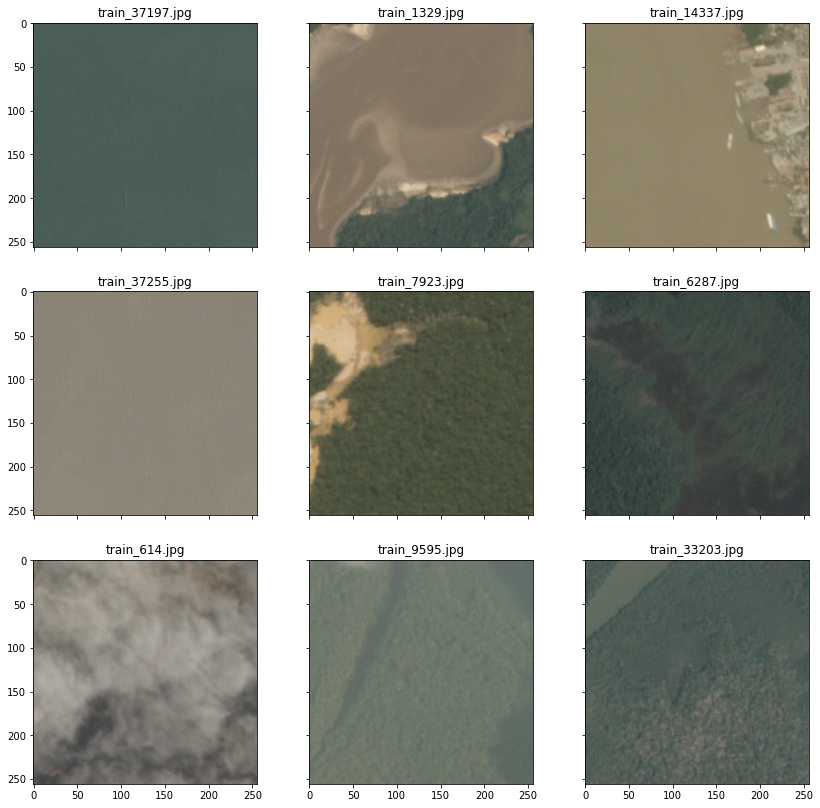

In [10]:
sampled_images = sample_images(['water'], n=9)
_, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(14, 14))

for i in range(len(sampled_images)):
    jpg = sample_to_fname(sampled_images, i, 'jpg')

    try:
        jpg_img = load_image(jpg)[:,:,:3]        
        
        ax[i // 3, i % 3].imshow(jpg_img)
        ax[i // 3, i % 3].set_title(jpg)
    except:
        continue

## Labeling functions - helper functions and preprocessing



In [11]:
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

def evaluate_LF(LF, df, tag, n=1000, full_dataset = False, print_evaluation=True):
    #print(namestr(LF, globals()))
    
    if full_dataset:
        n = df.shape[0]
    
    # Sample n images from the dataset
    sampled_images = df[:].sample(n)

    # Evaluate
    tp, fp, tn, fn = 0, 0, 0, 0
    abst = 0
    for index, row in sampled_images.iterrows():
        pred = LF(row)
        if pred == 1: 
            if row[tag] == 1:
                tp += 1
            else:
                fp += 1
        elif pred == 0:
            if row[tag] == 0:
                tn += 1
            else:
                fn += 1
        else:
            abst += 1  

    # Calculate the accuracy of LF
    accuracy = (tp + tn)/(tp + fp + tn + fn)
    precision = tp / (tp + fp)
    coverage = (n - abst) / n
    
    if print_evaluation:
        print('TP: ', tp)
        print('FP: ', fp)
        print('TN: ', tn)
        print('FN: ', fn)
        print('abstain: ', abst)
        print('accuracy: ', accuracy)
        print('precision: ', precision)
        print('coverage: ', coverage)
        
    return

In [12]:
# Splits of the original Kaggle dataset for training, validation and testing
SPLIT_TRAIN = 10000
SPLIT_VALIDATE = 12000

Load BigEarthNet remote sensing pre-trained model (Sentinel-2 data, 590k size)
https://arxiv.org/pdf/1911.06721.pdf

Model was subsequently trained on 12k (10k training, 2k validation) labeled jpg images from the Kaggle training dataset (see remote_sensing.py)

In [13]:
import tensorflow as tf
import tensorflow_hub as hub

batch_size = 128
heigth = 224
width = 224
no_channels = 3

# Create model and load model weights
#module = hub.KerasLayer("https://tfhub.dev/google/remote_sensing/bigearthnet-resnet50/1")
#model = tf.keras.Sequential([module,
#                             tf.keras.layers.Dense(17, activation="sigmoid")])
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.build(input_shape = (batch_size, heigth, width, no_channels))
#model.load_weights('../models/trained/bigearthnet-resnet_model_v05_weights.hdf5')
#model.summary()


/Users/rotti/.conda/envs/ee/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/rotti/.conda/envs/ee/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/rotti/.conda/envs/ee/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/rotti/.conda/envs/ee/lib/python3.7/site-packages/tensorflow/

Predict labels with the pre-trained model and set thresholds for abstaining

In [14]:
# Prepare array of images to predict classes with model
#x_train = []
y_train = []


for f, tags in tqdm(labels_df.loc[:,'image_name':'tags'].values, miniters=1000):
#    img = cv2.imread('../data/train-jpg/{}.jpg'.format(f))
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1
#    x_train.append(cv2.resize(img, (224, 224)))
    y_train.append(targets)    
    
# Normalize images into the interval [0,1]
y_train = np.array(y_train, np.uint8)
#x_train = np.array(x_train, np.float16) / 255.

#x_train, x_valid, x_test = (x_train[:SPLIT_TRAIN], x_train[SPLIT_TRAIN:SPLIT_VALIDATE], x_train[SPLIT_VALIDATE:])
y_train, y_valid, y_test = (y_train[:SPLIT_TRAIN], y_train[SPLIT_TRAIN:SPLIT_VALIDATE], y_train[SPLIT_VALIDATE:])


100%|██████████| 40479/40479 [00:00<00:00, 179356.54it/s]


In [15]:
# Predict
#p_train = model.predict(x_train, batch_size=128)
#p_valid = model.predict(x_valid, batch_size=128)
#p_test = model.predict(x_test, batch_size=128)

# Directly load predicted features for the complete dataset (computed on cluster)
p_train = np.genfromtxt('../models/predictions/features_bigearth_v06_p_train.csv', delimiter=',')
p_valid = np.genfromtxt('../models/predictions/features_bigearth_v06_p_valid.csv', delimiter=',')
p_test = np.genfromtxt('../models/predictions/features_bigearth_v06_p_test.csv', delimiter=',')

assert len(p_test)== len(y_test)

print(p_test[:3,:])
print(y_test[:3,:])

[[4.88168597e-01 9.80332732e-01 6.12525344e-02 3.62358421e-01
  4.12835777e-02 9.16162133e-03 3.38178575e-02 1.78963244e-02
  2.44247913e-03 9.82058048e-03 1.28939927e-01 1.61060691e-03
  1.01838410e-02 1.17114186e-03 7.61008263e-03 2.70891190e-03
  3.03727388e-03]
 [2.47734785e-03 9.92867112e-01 7.00310111e-01 8.13476682e-01
  2.47898936e-01 5.92001379e-02 1.32741868e-01 1.49581850e-01
  5.58599830e-03 5.37276268e-04 1.41373038e-01 3.11499834e-03
  9.06886160e-02 2.08328366e-02 1.02986693e-02 4.39661741e-03
  4.10342216e-03]
 [8.55540037e-01 8.89050007e-01 1.54513180e-01 4.68403995e-02
  1.61963075e-01 1.69787705e-02 5.77568710e-02 2.91395783e-02
  1.95530057e-03 1.02427930e-01 5.63713312e-02 2.09730864e-03
  1.07714236e-02 1.01163983e-03 1.61665678e-03 1.01438165e-03
  1.25804543e-03]]
[[0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0]]


In [16]:
# Set thresholds for voting positive and abstaining

import scipy.stats

def mean_confidence_interval(data, confidence=0.90):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h


resnet_thresholds = np.zeros((len(label_list),2))

# Calculate positive and abstain thresholds based on mean and std. deviation of predictions of train samples
for i in range(len(label_list)):
    arr = np.multiply(p_valid[:, i], y_valid[:, i])
    non_zero_arr = arr[np.where(arr!=0)]
    _, resnet_thresholds[i,0], _ = mean_confidence_interval(non_zero_arr)
    
    arr = np.multiply(p_valid[:, i], np.logical_not(y_valid[:, i]))
    non_zero_arr = arr[np.where(arr!=0)]
    _, _, resnet_thresholds[i,1] = np.minimum(mean_confidence_interval(non_zero_arr), resnet_thresholds[i,0])

print(resnet_thresholds[:,:])

[[ 4.34697135e-01  4.60413384e-02]
 [ 9.77005450e-01  5.27294026e-01]
 [ 6.45682334e-01  1.47399456e-01]
 [ 8.69168979e-01  2.65808712e-01]
 [ 5.42492332e-01  1.15322297e-01]
 [ 3.66905611e-01  5.96805918e-02]
 [ 5.89549578e-01  8.88502919e-02]
 [ 2.30557992e-01  7.09633402e-02]
 [ 2.47694539e-03  2.47694539e-03]
 [ 5.58929689e-01  1.20882850e-02]
 [ 5.91473136e-01  1.13720894e-01]
 [-1.19595617e-02 -1.19595617e-02]
 [ 8.03865766e-02  2.11557546e-02]
 [ 1.61002552e-01  5.49323834e-03]
 [ 1.96210605e-02  9.10638614e-03]
 [ 1.20344979e-02  7.95532241e-03]
 [ 4.81597143e-04  4.81597143e-04]]


Compute UMAP embedding for ResNet features to "draw" LFs in a plane as opposed to setting thresholds based on mean and std_dev

In [17]:
import umap.umap_ as umap

reducer = umap.UMAP(
    n_neighbors=60,
    min_dist=0.0,
    n_components=2,
    random_state=42,
)

#TBD: Is there a way to leverage the labels for p_train and p_valid as semi-supervised classification,
# given it is a multi-label problem? UMAP assumes single label classification (obviously)

#reducer.fit(np.concatenate((p_train,p_valid,p_test), axis = 0))
reducer.fit(p_test)

UMAP(a=None, angular_rp_forest=False, b=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=False, metric='euclidean',
     metric_kwds=None, min_dist=0.0, n_components=2, n_epochs=None,
     n_neighbors=60, negative_sample_rate=5, output_metric='euclidean',
     output_metric_kwds=None, random_state=42, repulsion_strength=1.0,
     set_op_mix_ratio=1.0, spread=1.0, target_metric='categorical',
     target_metric_kwds=None, target_n_neighbors=-1, target_weight=0.5,
     transform_queue_size=4.0, transform_seed=42, unique=False, verbose=False)

In [18]:
embedding_UMAP = reducer.transform(p_test) 

In [19]:
# Manually set polygons within UMAP embedding to cluster/label data for following labels:
# 0 - haze
# 1 - primary
# 2 - agriculture
# 3 - clear
# 4 - water
# 5 - habitation
# 6 - road
# 9 - cloudy
# 10 - partly_cloudy

# TBD: more precise polygons/bounding boxes including abstaining regions

from shapely.geometry import Point, Polygon

resnet_coords = [[] for i in range(17)]
resnet_coords[0] = [(6.2, 5), (6.2, 8), (9.0, 8), (9.0, 5)]
resnet_coords[1] = [(-6, -6), (-6, 7.5), (14, 7.5), (14, -6)]
resnet_coords[2] = [(5.5, -6), (5.5, 2), (11.5, 2), (11.5, -6)]
resnet_coords[3] = [(-6, -6), (-6, 6), (7, 6), (7, 0.9), (14, 0.9), (14, -6)]
resnet_coords[4] = [(10.5, -4.5), (10.5, 2.5), (14.5, 2.5), (14.5, -4.5)]
resnet_coords[5] = [(8, -5.5), (8, -3.2), (11.5, -3.2), (11.5, -5.5)]
resnet_coords[6] = [(8, -5.4), (8, 1.9), (11.5, 1.9), (11.5, -5.4)]
resnet_coords[9] = [(8.7, 6), (8.7, 11), (12.2, 11), (12.2, 6)]
resnet_coords[10] = [(5, 1.5), (5, 4.5), (8, 4.5), (8, 6), (13, 6), (13, -0.2), (9, -0.2), (9, 1.5)]

print(resnet_coords)

[[(6.2, 5), (6.2, 8), (9.0, 8), (9.0, 5)], [(-6, -6), (-6, 7.5), (14, 7.5), (14, -6)], [(5.5, -6), (5.5, 2), (11.5, 2), (11.5, -6)], [(-6, -6), (-6, 6), (7, 6), (7, 0.9), (14, 0.9), (14, -6)], [(10.5, -4.5), (10.5, 2.5), (14.5, 2.5), (14.5, -4.5)], [(8, -5.5), (8, -3.2), (11.5, -3.2), (11.5, -5.5)], [(8, -5.4), (8, 1.9), (11.5, 1.9), (11.5, -5.4)], [], [], [(8.7, 6), (8.7, 11), (12.2, 11), (12.2, 6)], [(5, 1.5), (5, 4.5), (8, 4.5), (8, 6), (13, 6), (13, -0.2), (9, -0.2), (9, 1.5)], [], [], [], [], [], []]


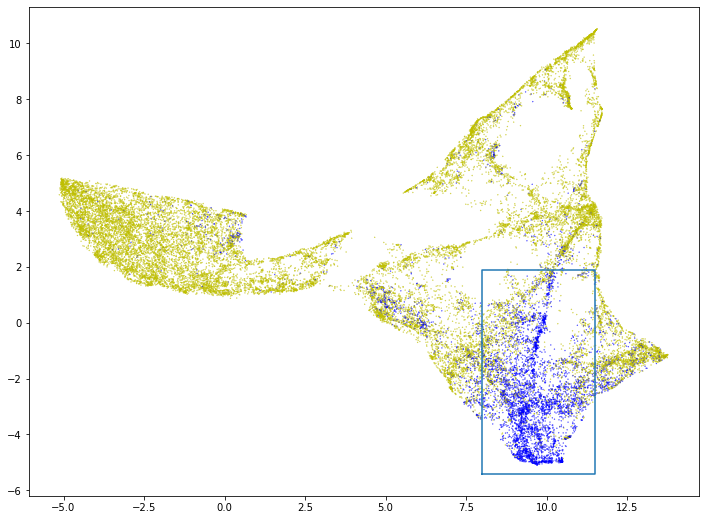

In [20]:
# Display manual clustering of the UMAP embedding

label_id = 6

coords = resnet_coords[label_id]
poly = Polygon(coords)

color = []
for i in range(len(y_test)):
#for i in range(600):
    if y_test[i,label_id] == 1:
        color.append('b') #
    else:
        color.append('y') #other

plt.figure(figsize=(12,9))
plt.scatter(embedding_UMAP[:, 0], embedding_UMAP[:, 1], c=color, s=0.1, cmap='Scatter')
#plt.scatter(embedding_UMAP[:600, 0], embedding_UMAP[:600, 1], c=color, s=0.1, cmap='Scatter')
plt.plot(*poly.exterior.xy)

Split df with labels for training, validation and testing datasets

In [21]:
labels_df_train = labels_df.iloc[:SPLIT_TRAIN]
labels_df_valid = labels_df.iloc[SPLIT_TRAIN:SPLIT_VALIDATE]
labels_df_test = labels_df.iloc[SPLIT_VALIDATE:]

## Labelling functions for selected classes

Classes considered: haze, primary, agriculture, clear, water, road, cloudy, partly_cloudy, habitation

In [22]:
# Define label mappings for Snorkle voting for convenience
NEGATIVE = 0
POSITIVE = 1
ABSTAIN = -1

In [23]:
# Define category mappings within labels_df for convenience
HAZE_MAP = 0
PRIMARY_MAP = 1
AGRICULTURE_MAP = 2
CLEAR_MAP = 3
WATER_MAP = 4
HABITATION_MAP = 5
ROAD_MAP = 6
CLOUDY_MAP = 9
PARTLY_CLOUDY_MAP = 10 

In [24]:
@labeling_function()
def habitation_ResNet_1(x):
    img_id = x.image_name.split("_")[1]
    i = int(img_id) - SPLIT_VALIDATE

    if p_test[i, HABITATION_MAP] > resnet_thresholds[HABITATION_MAP,0]:
        return POSITIVE
    elif p_test[i, HABITATION_MAP] > resnet_thresholds[HABITATION_MAP,1]:
        return ABSTAIN
    else:
        return NEGATIVE

In [25]:
evaluate_LF(habitation_ResNet_1, labels_df_test, 'habitation', full_dataset = False)

TP:  52
FP:  25
TN:  710
FN:  6
abstain:  207
accuracy:  0.9609079445145019
precision:  0.6753246753246753
coverage:  0.793


In [26]:
@labeling_function()
def habitation_ResNet_2(x):
    img_id = x.image_name.split("_")[1]
    i = int(img_id) - SPLIT_VALIDATE
    
    p1 = Point(embedding_UMAP[i, 0], embedding_UMAP[i, 1])
    coord = resnet_coords[HABITATION_MAP]
    poly = Polygon(coord)
    
    if p1.within(poly):
        return POSITIVE
    else:
        return NEGATIVE

In [27]:
evaluate_LF(habitation_ResNet_2, labels_df_test, 'habitation', full_dataset = False)

TP:  25
FP:  24
TN:  903
FN:  48
abstain:  0
accuracy:  0.928
precision:  0.5102040816326531
coverage:  1.0


In [28]:
@labeling_function()
def cloudy_ResNet_1(x):
    img_id = x.image_name.split("_")[1]
    i = int(img_id) - SPLIT_VALIDATE

    if p_test[i, CLOUDY_MAP] > resnet_thresholds[CLOUDY_MAP,0]:
        return POSITIVE
    elif p_test[i, CLOUDY_MAP] > resnet_thresholds[CLOUDY_MAP,1]:
        return ABSTAIN
    else:
        return NEGATIVE

In [29]:
evaluate_LF(cloudy_ResNet_1, labels_df_test, 'cloudy', full_dataset = False)

TP:  22
FP:  3
TN:  864
FN:  0
abstain:  111
accuracy:  0.9966254218222722
precision:  0.88
coverage:  0.889


In [30]:
@labeling_function()
def haze_ResNet_1(x):
    img_id = x.image_name.split("_")[1]
    i = int(img_id) - SPLIT_VALIDATE

    if p_test[i,HAZE_MAP] > resnet_thresholds[HAZE_MAP,0]:
        return POSITIVE
    elif p_test[i, HAZE_MAP] > resnet_thresholds[HAZE_MAP,1]:
        return ABSTAIN
    else:
        return NEGATIVE

In [31]:
evaluate_LF(haze_ResNet_1, labels_df_test, 'haze', full_dataset = False)

TP:  39
FP:  24
TN:  748
FN:  2
abstain:  187
accuracy:  0.968019680196802
precision:  0.6190476190476191
coverage:  0.813


In [32]:
@labeling_function()
def haze_ResNet_2(x):
    img_id = x.image_name.split("_")[1]
    i = int(img_id) - SPLIT_VALIDATE
    
    p1 = Point(embedding_UMAP[i, 0], embedding_UMAP[i, 1])
    coord = resnet_coords[HAZE_MAP]
    poly = Polygon(coord)
    
    if p1.within(poly):
        return POSITIVE
    else:
        return NEGATIVE

In [33]:
evaluate_LF(haze_ResNet_2, labels_df_test, 'haze', full_dataset = False)

TP:  38
FP:  9
TN:  928
FN:  25
abstain:  0
accuracy:  0.966
precision:  0.8085106382978723
coverage:  1.0


In [34]:
@labeling_function()
def primary_ResNet_1(x):
    img_id = x.image_name.split("_")[1]
    i = int(img_id) - SPLIT_VALIDATE

    if p_test[i,PRIMARY_MAP] > resnet_thresholds[PRIMARY_MAP,0]:
        return POSITIVE
    elif p_test[i, PRIMARY_MAP] > resnet_thresholds[PRIMARY_MAP,1]:
        return ABSTAIN
    else:
        return NEGATIVE

In [35]:
evaluate_LF(primary_ResNet_1, labels_df_test, 'primary', full_dataset = False)

TP:  778
FP:  5
TN:  46
FN:  7
abstain:  164
accuracy:  0.9856459330143541
precision:  0.9936143039591315
coverage:  0.836


In [36]:
@labeling_function()
def primary_ResNet_2(x):
    img_id = x.image_name.split("_")[1]
    i = int(img_id) - SPLIT_VALIDATE
    
    p1 = Point(embedding_UMAP[i, 0], embedding_UMAP[i, 1])
    coord = resnet_coords[PRIMARY_MAP]
    poly = Polygon(coord)
    
    if p1.within(poly):
        return POSITIVE
    else:
        return NEGATIVE

In [37]:
evaluate_LF(primary_ResNet_2, labels_df_test, 'primary', full_dataset = False)

TP:  913
FP:  30
TN:  45
FN:  12
abstain:  0
accuracy:  0.958
precision:  0.968186638388123
coverage:  1.0


In [38]:
@labeling_function()
def agriculture_ResNet_1(x):
    img_id = x.image_name.split("_")[1]
    i = int(img_id) - SPLIT_VALIDATE

    if p_test[i,AGRICULTURE_MAP] > resnet_thresholds[AGRICULTURE_MAP,0]:
        return POSITIVE
    elif p_test[i, AGRICULTURE_MAP] > resnet_thresholds[AGRICULTURE_MAP,1]:
        return ABSTAIN
    else:
        return NEGATIVE

In [39]:
evaluate_LF(agriculture_ResNet_1, labels_df_test, 'agriculture', full_dataset = False)

TP:  197
FP:  30
TN:  530
FN:  22
abstain:  221
accuracy:  0.9332477535301669
precision:  0.8678414096916299
coverage:  0.779


In [40]:
@labeling_function()
def agriculture_ResNet_2(x):
    img_id = x.image_name.split("_")[1]
    i = int(img_id) - SPLIT_VALIDATE
    
    p1 = Point(embedding_UMAP[i, 0], embedding_UMAP[i, 1])
    coord = resnet_coords[AGRICULTURE_MAP]
    poly = Polygon(coord)
    
    if p1.within(poly):
        return POSITIVE
    else:
        return NEGATIVE

In [41]:
evaluate_LF(agriculture_ResNet_2, labels_df_test, 'agriculture', full_dataset = False)

TP:  247
FP:  48
TN:  639
FN:  66
abstain:  0
accuracy:  0.886
precision:  0.8372881355932204
coverage:  1.0


In [42]:
@labeling_function()
def clear_ResNet_1(x):
    img_id = x.image_name.split("_")[1]
    i = int(img_id) - SPLIT_VALIDATE

    if p_test[i,CLEAR_MAP] > resnet_thresholds[CLEAR_MAP,0]:
        return POSITIVE
    elif p_test[i, CLEAR_MAP] > resnet_thresholds[CLEAR_MAP,1]:
        return ABSTAIN
    else:
        return NEGATIVE

In [43]:
evaluate_LF(clear_ResNet_1, labels_df_test, 'clear', full_dataset = False)

TP:  543
FP:  17
TN:  182
FN:  21
abstain:  237
accuracy:  0.9501965923984272
precision:  0.9696428571428571
coverage:  0.763


In [44]:
@labeling_function()
def clear_ResNet_2(x):
    img_id = x.image_name.split("_")[1]
    i = int(img_id) - SPLIT_VALIDATE
    
    p1 = Point(embedding_UMAP[i, 0], embedding_UMAP[i, 1])
    coord = resnet_coords[CLEAR_MAP]
    poly = Polygon(coord)
    
    if p1.within(poly):
        return POSITIVE
    else:
        return NEGATIVE

In [45]:
evaluate_LF(clear_ResNet_2, labels_df_test, 'clear', full_dataset = False)

TP:  689
FP:  106
TN:  190
FN:  15
abstain:  0
accuracy:  0.879
precision:  0.8666666666666667
coverage:  1.0


In [46]:
@labeling_function()
def water_ResNet_1(x):
    img_id = x.image_name.split("_")[1]
    i = int(img_id) - SPLIT_VALIDATE

    if p_test[i,WATER_MAP] > resnet_thresholds[WATER_MAP,0]:
        return POSITIVE
    elif p_test[i, WATER_MAP] > resnet_thresholds[WATER_MAP,1]:
        return ABSTAIN
    else:
        return NEGATIVE

In [47]:
evaluate_LF(water_ResNet_1, labels_df_test, 'water', full_dataset = True)

TP:  2828
FP:  652
TN:  17018
FN:  504
abstain:  7477
accuracy:  0.9449576230835158
precision:  0.8126436781609195
coverage:  0.7374556690895046


In [48]:
@labeling_function()
def water_ResNet_2(x):
    img_id = x.image_name.split("_")[1]
    i = int(img_id) - SPLIT_VALIDATE
    
    p1 = Point(embedding_UMAP[i, 0], embedding_UMAP[i, 1])
    coord = resnet_coords[WATER_MAP]
    poly = Polygon(coord)
    
    if p1.within(poly):
        return POSITIVE
    else:
        return NEGATIVE

In [49]:
evaluate_LF(water_ResNet_2, labels_df_test, 'water', full_dataset = True)

TP:  2688
FP:  489
TN:  22776
FN:  2526
abstain:  0
accuracy:  0.894132518697988
precision:  0.846081208687441
coverage:  1.0


In [50]:
@labeling_function()
def road_ResNet_1(x):
    img_id = x.image_name.split("_")[1]
    i = int(img_id) - SPLIT_VALIDATE

    if p_test[i,ROAD_MAP] > resnet_thresholds[ROAD_MAP,0]:
        return POSITIVE
    elif p_test[i, ROAD_MAP] > resnet_thresholds[ROAD_MAP,1]:
        return ABSTAIN
    else:
        return NEGATIVE

In [51]:
evaluate_LF(road_ResNet_1, labels_df_test, 'road', full_dataset = False)

TP:  116
FP:  16
TN:  616
FN:  11
abstain:  241
accuracy:  0.9644268774703557
precision:  0.8787878787878788
coverage:  0.759


In [52]:
@labeling_function()
def road_ResNet_2(x):
    img_id = x.image_name.split("_")[1]
    i = int(img_id) - SPLIT_VALIDATE
    
    p1 = Point(embedding_UMAP[i, 0], embedding_UMAP[i, 1])
    coord = resnet_coords[ROAD_MAP]
    poly = Polygon(coord)
    
    if p1.within(poly):
        return POSITIVE
    else:
        return NEGATIVE

In [53]:
evaluate_LF(road_ResNet_2, labels_df_test, 'road', full_dataset = False)

TP:  166
FP:  83
TN:  709
FN:  42
abstain:  0
accuracy:  0.875
precision:  0.6666666666666666
coverage:  1.0


In [54]:
@labeling_function()
def cloudy_ResNet_1(x):
    img_id = x.image_name.split("_")[1]
    i = int(img_id) - SPLIT_VALIDATE

    if p_test[i,CLOUDY_MAP] > resnet_thresholds[CLOUDY_MAP,0]:
        return POSITIVE
    elif p_test[i, CLOUDY_MAP] > resnet_thresholds[CLOUDY_MAP,1]:
        return ABSTAIN
    else:
        return NEGATIVE

In [55]:
evaluate_LF(cloudy_ResNet_1, labels_df_test, 'cloudy', full_dataset = True)

TP:  908
FP:  125
TN:  24681
FN:  7
abstain:  2758
accuracy:  0.9948680066871428
precision:  0.8789932236205228
coverage:  0.9031567119632009


In [56]:
@labeling_function()
def cloudy_ResNet_2(x):
    img_id = x.image_name.split("_")[1]
    i = int(img_id) - SPLIT_VALIDATE
    
    p1 = Point(embedding_UMAP[i, 0], embedding_UMAP[i, 1])
    coord = resnet_coords[CLOUDY_MAP]
    poly = Polygon(coord)
    
    if p1.within(poly):
        return POSITIVE
    else:
        return NEGATIVE

In [57]:
evaluate_LF(cloudy_ResNet_2, labels_df_test, 'cloudy', full_dataset = False)

TP:  43
FP:  21
TN:  929
FN:  7
abstain:  0
accuracy:  0.972
precision:  0.671875
coverage:  1.0


In [58]:
@labeling_function()
def partly_cloudy_ResNet_1(x):
    img_id = x.image_name.split("_")[1]
    i = int(img_id) - SPLIT_VALIDATE

    if p_test[i,PARTLY_CLOUDY_MAP] > resnet_thresholds[PARTLY_CLOUDY_MAP,0]:
        return POSITIVE
    elif p_test[i, PARTLY_CLOUDY_MAP] > resnet_thresholds[PARTLY_CLOUDY_MAP,1]:
        return ABSTAIN
    else:
        return NEGATIVE

In [59]:
evaluate_LF(partly_cloudy_ResNet_1, labels_df_test, 'partly_cloudy', full_dataset = False)

TP:  90
FP:  10
TN:  629
FN:  14
abstain:  257
accuracy:  0.9676985195154778
precision:  0.9
coverage:  0.743


In [60]:
@labeling_function()
def partly_cloudy_ResNet_2(x):
    img_id = x.image_name.split("_")[1]
    i = int(img_id) - SPLIT_VALIDATE
    
    p1 = Point(embedding_UMAP[i, 0], embedding_UMAP[i, 1])
    coord = resnet_coords[PARTLY_CLOUDY_MAP]
    poly = Polygon(coord)
    
    if p1.within(poly):
        return POSITIVE
    else:
        return NEGATIVE

In [61]:
evaluate_LF(partly_cloudy_ResNet_2, labels_df_test, 'partly_cloudy', full_dataset = True)

TP:  3674
FP:  941
TN:  22425
FN:  1439
abstain:  0
accuracy:  0.9164296499174831
precision:  0.7960996749729145
coverage:  1.0


In [62]:
@labeling_function()
def cloudy_histogram_1(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
    
    jpg_img = load_image(jpg)[:,:,:3]
    
    COEFF_PERCENTILE = 40
    COEFF_1 = 140
    COEFF_2 = 120
    
    perc = np.percentile(jpg_img, COEFF_PERCENTILE)
    
    if perc > COEFF_1:
        return POSITIVE
    elif perc > COEFF_2:
        return ABSTAIN
    else:
        return NEGATIVE

In [63]:
evaluate_LF(cloudy_histogram_1, labels_df_test, 'cloudy', full_dataset = False)

TP:  36
FP:  26
TN:  875
FN:  5
abstain:  58
accuracy:  0.9670912951167728
precision:  0.5806451612903226
coverage:  0.942


In [64]:
@labeling_function()
def cloudy_histogram_2(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
    
    jpg_img = load_image(jpg)[:,:,:3]
    
    COEFF_PERCENTILE = 80
    COEFF_1 = 140
    COEFF_2 = 115
    
    perc = np.percentile(jpg_img, COEFF_PERCENTILE)
    
    if perc > COEFF_1:
        return POSITIVE
    elif perc > COEFF_2:
        return ABSTAIN
    else:
        return NEGATIVE

In [65]:
evaluate_LF(cloudy_histogram_2, labels_df_test, 'cloudy', full_dataset = False)

TP:  51
FP:  84
TN:  733
FN:  5
abstain:  127
accuracy:  0.8980526918671249
precision:  0.37777777777777777
coverage:  0.873


In [66]:
@labeling_function()
def partly_cloudy_histogram_1(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
    
    jpg_img = load_image(jpg)[:,:,:3]
    
    COEFF_PERCENTILE_1 = 80
    COEFF_PERCENTILE_2 = 30
    COEFF_1 = 30
    COEFF_2 = 10
    
    perc = np.percentile(jpg_img, COEFF_PERCENTILE_1) - np.percentile(jpg_img, COEFF_PERCENTILE_2)
    
    if perc > COEFF_1:
        return POSITIVE
    elif perc > COEFF_2:
        return ABSTAIN
    else:
        return NEGATIVE

In [67]:
evaluate_LF(partly_cloudy_histogram_1, labels_df_test, 'partly_cloudy', full_dataset = False)

TP:  56
FP:  71
TN:  220
FN:  21
abstain:  632
accuracy:  0.75
precision:  0.4409448818897638
coverage:  0.368


In [68]:
@labeling_function()
def partly_cloudy_histogram_2(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
    
    jpg_img = load_image(jpg)[:,:,:3]
    
    COEFF_PERCENTILE_1 = 5
    COEFF_PERCENTILE_2 = 98
    COEFF_1 = 70
    COEFF_2 = 20
    
    perc = np.percentile(jpg_img, COEFF_PERCENTILE_2) - np.percentile(jpg_img, COEFF_PERCENTILE_1)
    
    if perc > COEFF_1:
        return POSITIVE
    elif perc > COEFF_2:
        return ABSTAIN
    else:
        return NEGATIVE

In [69]:
evaluate_LF(partly_cloudy_histogram_2, labels_df_test, 'partly_cloudy', full_dataset = False)

TP:  113
FP:  116
TN:  51
FN:  0
abstain:  720
accuracy:  0.5857142857142857
precision:  0.49344978165938863
coverage:  0.28


In [70]:
@labeling_function()
def haze_histogram_1(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
    
    jpg_img = load_image(jpg)[:,:,:3]
    
    COEFF_PERCENTILE = 80
    COEFF_1 = 105
    COEFF_2 = 140
    COEFF_3 = 160
    COEFF_4 = 90
    
    perc = np.percentile(jpg_img, COEFF_PERCENTILE)
    
    if (COEFF_1 < perc < COEFF_2):
        return POSITIVE
    elif (perc > COEFF_3) or ( perc < COEFF_4) :
        return NEGATIVE
    else:
        return ABSTAIN

In [71]:
evaluate_LF(haze_histogram_1, labels_df_test, 'haze', full_dataset = False)

TP:  37
FP:  134
TN:  640
FN:  4
abstain:  185
accuracy:  0.8306748466257668
precision:  0.21637426900584794
coverage:  0.815


In [72]:
@labeling_function()
def haze_histogram_2(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
    
    jpg_img = load_image(jpg)[:,:,:3]
    
    COEFF_PERCENTILE_1 = 5
    COEFF_PERCENTILE_2 = 98
    COEFF_1 = 16
    COEFF_2 = 25
    COEFF_3 = 70
    
    perc = np.percentile(jpg_img, COEFF_PERCENTILE_2) - np.percentile(jpg_img, COEFF_PERCENTILE_1)
    
    if (COEFF_1 < perc < COEFF_2):
        return POSITIVE
    elif perc > COEFF_3:
        return NEGATIVE
    else:
        return ABSTAIN

In [73]:
evaluate_LF(haze_histogram_2, labels_df_test, 'haze', full_dataset = False)

TP:  29
FP:  90
TN:  199
FN:  1
abstain:  681
accuracy:  0.7147335423197492
precision:  0.24369747899159663
coverage:  0.319


In [74]:
@labeling_function()
def clear_histogram_1(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
    
    jpg_img = load_image(jpg)[:,:,:3]
    
    COEFF_PERCENTILE = 80
    COEFF_1 = 80
    COEFF_2 = 155
    
    perc = np.percentile(jpg_img, COEFF_PERCENTILE)
    
    if perc < COEFF_1:
        return POSITIVE
    elif perc < COEFF_2:
        return ABSTAIN
    else:
        return NEGATIVE

In [75]:
evaluate_LF(clear_histogram_1, labels_df_test, 'clear', full_dataset = False)

TP:  441
FP:  57
TN:  53
FN:  10
abstain:  439
accuracy:  0.8805704099821747
precision:  0.8855421686746988
coverage:  0.561


In [76]:
@labeling_function()
def clear_histogram_2(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
    
    jpg_img = load_image(jpg)[:,:,:3]
    
    COEFF_PERCENTILE_1 = 5
    COEFF_PERCENTILE_2 = 98
    COEFF_1 = 24
    COEFF_2 = 40
    COEFF_3 = 20
    COEFF_4 = 100
    
    perc = np.percentile(jpg_img, COEFF_PERCENTILE_2) - np.percentile(jpg_img, COEFF_PERCENTILE_1)
    
    if (COEFF_1 < perc < COEFF_2):
        return POSITIVE
    elif (perc < COEFF_3) or (perc > COEFF_4):
        return NEGATIVE
    else:
        return ABSTAIN

In [77]:
evaluate_LF(clear_histogram_2, labels_df_test, 'clear', full_dataset = False)

TP:  359
FP:  43
TN:  83
FN:  45
abstain:  470
accuracy:  0.8339622641509434
precision:  0.8930348258706468
coverage:  0.53


In [78]:
@labeling_function()
def clear_histogram_3(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
    
    jpg_img = load_image(jpg)[:,:,:3]
    
    COEFF_PERCENTILE = 5
    COEFF_1 = 75
    COEFF_2 = 120
    
    perc = np.percentile(jpg_img, COEFF_PERCENTILE)
    
    if (perc < COEFF_1):
        return POSITIVE
    elif (perc > COEFF_2):
        return NEGATIVE
    else:
        return ABSTAIN

In [79]:
evaluate_LF(clear_histogram_3, labels_df_test, 'clear', full_dataset = False)

TP:  602
FP:  122
TN:  66
FN:  4
abstain:  206
accuracy:  0.8413098236775819
precision:  0.8314917127071824
coverage:  0.794


In [80]:
@labeling_function()
def green_cover(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
   
    jpg_img = load_image(jpg)[:,:,:3]
    
    COEFF_MEAN_PRIMARY = 100
    COEFF_BORDER_PRIMARY = 150
    COEFF_1 = 1.045
    COEFF_2 = 1.05
    COEFF_3 = 1.09
    COEFF_4 = 1.00
    
    mean_r = np.mean(jpg_img[:,:,0])
    mean_g = np.mean(jpg_img[:,:,1])
    mean_b = np.mean(jpg_img[:,:,2])
    mean = (mean_r + mean_g + mean_b)/3.
    
    if (mean_g > COEFF_1*mean) and (mean < COEFF_BORDER_PRIMARY):
        return POSITIVE
    elif (mean_r > COEFF_2*mean) and (mean_r > COEFF_3*mean_b) \
            and (mean_g < COEFF_4*mean_r) and (COEFF_MEAN_PRIMARY > COEFF_MEAN_PRIMARY) :
        return NEGATIVE
    else:
        return ABSTAIN

In [81]:
evaluate_LF(green_cover, labels_df_test, 'primary', full_dataset = False)

TP:  816
FP:  7
TN:  0
FN:  0
abstain:  177
accuracy:  0.991494532199271
precision:  0.991494532199271
coverage:  0.823


In [82]:
@labeling_function()
def straight_road(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
   
    jpg_img = load_image(jpg)[:,:,:3]
    
    LOWER_CANNY = 30
    UPPER_CANNY = 45
    APPERTURE = 3
    KERNEL_SIZE = (5,5)
    ALPHA = 1.2
    BETA = -50
    RESIZE_WIDTH = 120
    RESIZE_HEIGHT = 120
    HOUGH_THRESHOLD = 40
    HOUGH_MIN_LINE_LENGTH = 80
    HOUGH_MAX_LINE_GAP = 7
    
    img = cv2.resize(jpg_img, (RESIZE_WIDTH, RESIZE_HEIGHT))
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    adjusted = cv2.convertScaleAbs(gray, alpha=ALPHA, beta=BETA)
    blurred = cv2.GaussianBlur(adjusted, KERNEL_SIZE, 0)

    
    #SIGMA=0.33
    # compute the median of the single channel pixel intensities
    #v = np.median(adjusted)
    # apply automatic Canny edge detection using the computed median
    #LOWER_CANNY = int(max(0, (1.0 - SIGMA) * v))
    #UPPER_CANNY = int(min(255, (1.0 + SIGMA) * v))
    #edges = cv2.Canny(blurred, lower, upper, APPERTURE)
    
    edges = cv2.Canny(blurred, LOWER_CANNY, UPPER_CANNY, APPERTURE)

    lines = []
    lines = cv2.HoughLinesP(edges,1,np.pi/180, HOUGH_THRESHOLD, minLineLength = HOUGH_MIN_LINE_LENGTH,\
                            maxLineGap = HOUGH_MAX_LINE_GAP)
    try:
        if lines == None:
            return NEGATIVE
    except:
        return POSITIVE

In [83]:
evaluate_LF(straight_road, labels_df_test, 'road', full_dataset = False)

TP:  48
FP:  38
TN:  745
FN:  169
abstain:  0
accuracy:  0.793
precision:  0.5581395348837209
coverage:  1.0


In [84]:
@labeling_function()
def water_edge(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
   
    jpg_img = load_image(jpg)[:,:,:3]
    
    LOWER_CANNY = 30
    UPPER_CANNY = 45
    APPERTURE = 3
    KERNEL_SIZE = (5,5)
    ALPHA = 1.2
    BETA = -50
    RESIZE_WIDTH = 120
    RESIZE_HEIGHT = 120
    HOUGH_THRESHOLD = 40
    
    HOUGH_MIN_LINE_LENGTH_ROAD = 80
    HOUGH_MAX_LINE_GAP_ROAD = 7
    
    HOUGH_MIN_LINE_LENGTH_WATER = 40
    HOUGH_MAX_LINE_GAP_WATER = 20


    img = cv2.resize(jpg_img, (RESIZE_WIDTH, RESIZE_HEIGHT))
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    adjusted = cv2.convertScaleAbs(gray, alpha=ALPHA, beta=BETA)
    blurred = cv2.GaussianBlur(adjusted, KERNEL_SIZE, 0)

    
    #SIGMA=0.33
    # compute the median of the single channel pixel intensities
    #v = np.median(adjusted)
    # apply automatic Canny edge detection using the computed median
    #LOWER_CANNY = int(max(0, (1.0 - SIGMA) * v))
    #UPPER_CANNY = int(min(255, (1.0 + SIGMA) * v))
    #edges = cv2.Canny(blurred, LOWER_CANNY, UPPER_CANNY, APPERTURE)
    
    edges = cv2.Canny(blurred, LOWER_CANNY, UPPER_CANNY, APPERTURE)

    lines_road = []
    lines_road = cv2.HoughLinesP(edges,1,np.pi/180, HOUGH_THRESHOLD, minLineLength = HOUGH_MIN_LINE_LENGTH_ROAD,\
                            maxLineGap = HOUGH_MAX_LINE_GAP_ROAD)
    
    lines_water = []
    lines_water = cv2.HoughLinesP(edges,1,np.pi/180, HOUGH_THRESHOLD, minLineLength = HOUGH_MIN_LINE_LENGTH_WATER,\
                            maxLineGap = HOUGH_MAX_LINE_GAP_WATER)
    try:
        if lines_water == None:
            return NEGATIVE
    except:
        try:
            if lines_road == None:
                return POSITIVE
            else:
                return NEGATIVE
        except: return ABSTAIN

In [85]:
evaluate_LF(water_edge, labels_df_test, 'water', full_dataset = False)

TP:  76
FP:  152
TN:  610
FN:  88
abstain:  74
accuracy:  0.7408207343412527
precision:  0.3333333333333333
coverage:  0.926


In [86]:
@labeling_function()
def water_curved(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
   
    jpg_img = load_image(jpg)[:,:,:3]
    
    LOWER_CANNY = 30
    UPPER_CANNY = 45
    APPERTURE = 3
    KERNEL_SIZE = (5,5)
    ALPHA = 1.2
    BETA = -50
    RESIZE_WIDTH = 120
    RESIZE_HEIGHT = 120

    PERI_LOW = 200
    AREA_HIGH = 60
    PERI_AREA_RATIO = 7.5
    

    img = cv2.resize(jpg_img, (RESIZE_WIDTH, RESIZE_HEIGHT))
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    adjusted = cv2.convertScaleAbs(gray, alpha=ALPHA, beta=BETA)
    blurred = cv2.GaussianBlur(adjusted, KERNEL_SIZE, 0)

    
    #SIGMA=0.33
    # compute the median of the single channel pixel intensities
    #v = np.median(adjusted)
    # apply automatic Canny edge detection using the computed median
    #LOWER_CANNY = int(max(0, (1.0 - SIGMA) * v))
    #UPPER_CANNY = int(min(255, (1.0 + SIGMA) * v))
    #edges = cv2.Canny(blurred, LOWER_CANNY, UPPER_CANNY, APPERTURE)
    
    edges = cv2.Canny(blurred, LOWER_CANNY, UPPER_CANNY, APPERTURE)

    # find contours in the edged image
    cnts = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    # select top 5 contours by area
    cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]
    
    curve_ok = False
    # loop over the contours
    for c in cnts:
        # approximate the contour
        peri = cv2.arcLength(c, True)
        area = cv2.contourArea(c)
        if peri > PERI_LOW and area < AREA_HIGH and peri/max(area,0.01) > PERI_AREA_RATIO:
            curve_ok = True
    try:    
        if curve_ok:
            return POSITIVE
        else:
            return NEGATIVE
    except: return ABSTAIN

In [87]:
evaluate_LF(water_curved, labels_df_test, 'water', full_dataset = False)

TP:  41
FP:  71
TN:  742
FN:  146
abstain:  0
accuracy:  0.783
precision:  0.36607142857142855
coverage:  1.0


In [88]:
@labeling_function()
def road_edge(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
   
    jpg_img = load_image(jpg)[:,:,:3]
    
    LOWER_CANNY = 30
    UPPER_CANNY = 45
    APPERTURE = 3
    KERNEL_SIZE = (5,5)
    ALPHA = 1.2
    BETA = -50
    RESIZE_WIDTH = 120
    RESIZE_HEIGHT = 120
    HOUGH_THRESHOLD = 40
    
    HOUGH_MIN_LINE_LENGTH_ROAD = 80
    HOUGH_MAX_LINE_GAP_ROAD = 7
    
    HOUGH_MIN_LINE_LENGTH_WATER = 40
    HOUGH_MAX_LINE_GAP_WATER = 20


    img = cv2.resize(jpg_img, (RESIZE_WIDTH, RESIZE_HEIGHT))
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    adjusted = cv2.convertScaleAbs(gray, alpha=ALPHA, beta=BETA)
    blurred = cv2.GaussianBlur(adjusted, KERNEL_SIZE, 0)

    
    #SIGMA=0.33
    # compute the median of the single channel pixel intensities
    #v = np.median(adjusted)
    # apply automatic Canny edge detection using the computed median
    #LOWER_CANNY = int(max(0, (1.0 - SIGMA) * v))
    #UPPER_CANNY = int(min(255, (1.0 + SIGMA) * v))
    #edges = cv2.Canny(blurred, LOWER_CANNY, UPPER_CANNY, APPERTURE)
    
    edges = cv2.Canny(blurred, LOWER_CANNY, UPPER_CANNY, APPERTURE)

    lines_road = []
    lines_road = cv2.HoughLinesP(edges,1,np.pi/180, HOUGH_THRESHOLD, minLineLength = HOUGH_MIN_LINE_LENGTH_ROAD,\
                            maxLineGap = HOUGH_MAX_LINE_GAP_ROAD)
    
    lines_water = []
    lines_water = cv2.HoughLinesP(edges,1,np.pi/180, HOUGH_THRESHOLD, minLineLength = HOUGH_MIN_LINE_LENGTH_WATER,\
                            maxLineGap = HOUGH_MAX_LINE_GAP_WATER)
    try:
        if lines_road == None:
            return NEGATIVE
    except:
        return POSITIVE


In [89]:
evaluate_LF(road_edge, labels_df_test, 'road', full_dataset = False)

TP:  56
FP:  19
TN:  789
FN:  136
abstain:  0
accuracy:  0.845
precision:  0.7466666666666667
coverage:  1.0


### LFs - KNN

In [90]:
SPLIT_TRAIN_KNN = 500
SPLIT_VALIDATE_KNN = 600

In [91]:
# Green_cover KNN training

x_green_cover_train = []
y_green_cover_train = []

#for f, tags in tqdm(labels_df.loc[:SPLIT_VALIDATE_KNN,'image_name':'tags'].values, miniters=1000):
for f, tags in tqdm(labels_df.loc[:,'image_name':'tags'].values, miniters=1000):
    img = cv2.imread('../data/train-jpg/{}.jpg'.format(f))
    mean_r = np.mean(img[:,:,0])
    mean_g = np.mean(img[:,:,1])
    mean_b = np.mean(img[:,:,2])
    mean = (mean_r + mean_g + mean_b)/3.
    x_green_cover_train.append([mean_r, mean_g, mean_b, mean])   
    targets = np.zeros(1)
    for t in tags.split(' '):
        if t == 'primary':
            targets[0] = 1
    y_green_cover_train.append(targets)
  
#np.save('features_MeanColorSpace_Kaggle.npy', x_green_cover_train) 
    
x_green_cover_train, x_green_cover_valid, x_green_cover_test = (x_green_cover_train[:SPLIT_TRAIN_KNN],\
                                                                x_green_cover_train[SPLIT_TRAIN_KNN:SPLIT_VALIDATE_KNN],\
                                                                x_green_cover_train[SPLIT_VALIDATE_KNN:])
y_green_cover_train, y_green_cover_valid, y_green_cover_test = (y_green_cover_train[:SPLIT_TRAIN_KNN],\
                                                                y_green_cover_train[SPLIT_TRAIN_KNN:SPLIT_VALIDATE_KNN],\
                                                                y_green_cover_train[SPLIT_VALIDATE_KNN:])

#print(x_green_cover_train)
#print(y_green_cover_train)

100%|██████████| 40479/40479 [06:25<00:00, 105.04it/s]


In [92]:
print(x_green_cover_train)
print(y_green_cover_train)

[[104.60914611816406, 110.34700012207031, 92.78738403320312, 102.5811767578125], [65.30158996582031, 77.49737548828125, 66.63986206054688, 69.81294250488281], [57.86199951171875, 59.03938293457031, 44.16447448730469, 53.688618977864586], [54.97296142578125, 66.25376892089844, 52.41131591796875, 57.87934875488281], [20.525054931640625, 46.25340270996094, 58.342376708984375, 41.70694478352865], [148.83291625976562, 157.72348022460938, 152.69985961914062, 153.08541870117188], [103.27005004882812, 113.08566284179688, 101.52986145019531, 105.96185811360677], [100.57574462890625, 116.6785888671875, 111.97471618652344, 109.74301656087239], [34.29588317871094, 55.23558044433594, 42.568572998046875, 44.033345540364586], [128.88919067382812, 145.64022827148438, 149.4497528076172, 141.3263905843099], [51.721038818359375, 58.27171325683594, 56.32286071777344, 55.43853759765625], [67.92695617675781, 65.54093933105469, 48.91007995605469, 60.79265848795573], [147.8628692626953, 156.11827087402344, 15

In [93]:
neigh_green_cover = KNeighborsClassifier(n_neighbors=2)
neigh_green_cover.fit(x_green_cover_train, y_green_cover_train)

/Users/rotti/.conda/envs/ee/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [94]:
@labeling_function()
def green_cover_KNN(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
   
    jpg_img = load_image(jpg)[:,:,:3]
    
    mean_r = np.mean(jpg_img[:,:,0])
    mean_g = np.mean(jpg_img[:,:,1])
    mean_b = np.mean(jpg_img[:,:,2])
    mean = (mean_r + mean_g + mean_b)/3.
    
    pred = neigh_green_cover.predict(np.array([mean_r, mean_g, mean_b, mean]).reshape(1, -1))
     
    if pred == 1.0:
        return POSITIVE
    else:
        return NEGATIVE
    

In [95]:
evaluate_LF(green_cover_KNN, labels_df_test, 'primary', full_dataset = False)

TP:  842
FP:  25
TN:  46
FN:  87
abstain:  0
accuracy:  0.888
precision:  0.9711649365628604
coverage:  1.0


In [96]:
# water_curved KNN training

x_water_curved_train = []
y_water_curved_train = []

LOWER_CANNY = 30
UPPER_CANNY = 45
APPERTURE = 3
KERNEL_SIZE = (5,5)
ALPHA = 1.2
BETA = -50
RESIZE_WIDTH = 120
RESIZE_HEIGHT = 120
CNT_CONTOURS = 5
    
for f, tags in tqdm(labels_df.loc[:,'image_name':'tags'].values, miniters=1000):
    img = cv2.imread('../data/train-jpg/{}.jpg'.format(f))
    img = cv2.resize(img, (RESIZE_WIDTH, RESIZE_HEIGHT))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    adjusted = cv2.convertScaleAbs(gray, alpha=ALPHA, beta=BETA)
    blurred = cv2.GaussianBlur(adjusted, KERNEL_SIZE, 0)
    edges = cv2.Canny(blurred, LOWER_CANNY, UPPER_CANNY, APPERTURE)
    # find contours in the edged image
    cnts = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    # select top CNT_CONTOURS contours by area
    cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:CNT_CONTOURS]
    features = [0.,0.,0.,0.,0.,0.,0.,0.,0.,0.]
    # loop over the contours
    for i, c in enumerate(cnts):
        # approximate the contour
        peri = cv2.arcLength(c, True)
        area = cv2.contourArea(c)
        features[i*2] = peri
        features[i*2 + 1] = area
    
    x_water_curved_train.append(features)
    
    targets = np.zeros(1)
    for t in tags.split(' '):
        if t == 'water':
            targets[0] = 1
    y_water_curved_train.append(targets)
  

#np.save('features_CannyEdgeSpace_Kaggle.npy', x_water_curved_train)

x_water_curved_train, x_water_curved_valid, x_water_curved_test = (x_water_curved_train[:SPLIT_TRAIN_KNN],\
                                                                x_water_curved_train[SPLIT_TRAIN_KNN:SPLIT_VALIDATE_KNN],\
                                                                x_water_curved_train[SPLIT_VALIDATE_KNN:])
y_water_curved_train, y_water_curved_valid, y_water_curved_test = (y_water_curved_train[:SPLIT_TRAIN_KNN],\
                                                                y_water_curved_train[SPLIT_TRAIN_KNN:SPLIT_VALIDATE_KNN],\
                                                                y_water_curved_train[SPLIT_VALIDATE_KNN:])

print(x_water_curved_train)
print(y_water_curved_train)

100%|██████████| 40479/40479 [07:38<00:00, 88.23it/s] 


[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [71.59797894954681, 61.0, 35.79898953437805, 50.0, 281.0782080888748, 35.0, 221.27921795845032, 26.0, 149.48022854328156, 24.0], [12.828427076339722, 9.0, 9.071067690849304, 5.5, 26.14213538169861, 4.0, 24.727921724319458, 3.5, 24.97056245803833, 3.0], [16.242640614509583, 16.5, 13.899494767189026, 13.5, 64.7695517539978, 9.0, 44.52691113948822, 8.5, 12.242640614509583, 7.5], [131.7817440032959, 37.5, 72.52691113948822, 35.5, 23.55634880065918, 24.5, 25.656854152679443, 24.0, 132.2253954410553, 23.0], [21.899494767189026, 22.5, 18.727921843528748, 18.5, 45.35533845424652, 11.5, 85.8406194448471, 11.5, 12.828427076339722, 1.0], [158.06601476669312, 27.5, 82.81118142604828, 15.5, 120.7106763124466, 14.0, 25.55634880065918, 13.5, 68.42640590667725, 13.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [449.83051347732544, 79.5, 31.899494767189026, 64.5, 30.14213538169861, 60.0, 21.313708305358887, 30.0, 18.97056221961975, 23.0], [2

In [97]:
neigh_water_curved = KNeighborsClassifier(n_neighbors=2)
neigh_water_curved.fit(x_water_curved_train, y_water_curved_train)

/Users/rotti/.conda/envs/ee/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [98]:
@labeling_function()
def water_curved_KNN(x):
    jpg = '{}.{}'.format(x.image_name, 'jpg')
   
    jpg_img = load_image(jpg)[:,:,:3]
    
    LOWER_CANNY = 30
    UPPER_CANNY = 45
    APPERTURE = 3
    KERNEL_SIZE = (5,5)
    ALPHA = 1.2
    BETA = -50
    RESIZE_WIDTH = 120
    RESIZE_HEIGHT = 120
    CNT_CONTOURS = 5

    img = cv2.resize(jpg_img, (RESIZE_WIDTH, RESIZE_HEIGHT))
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    adjusted = cv2.convertScaleAbs(gray, alpha=ALPHA, beta=BETA)
    blurred = cv2.GaussianBlur(adjusted, KERNEL_SIZE, 0)

    
    edges = cv2.Canny(blurred, LOWER_CANNY, UPPER_CANNY, APPERTURE)

    # find contours in the edged image
    cnts = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
     # select top CNT_CONTOURS contours by area
    cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:CNT_CONTOURS]
    features = [0.,0.,0.,0.,0.,0.,0.,0.,0.,0.]
    # loop over the contours
    for i, c in enumerate(cnts):
        # approximate the contour
        peri = cv2.arcLength(c, True)
        area = cv2.contourArea(c)
        features[i*2] = peri
        features[i*2 + 1] = area
        
        
    pred = neigh_water_curved.predict(np.array(features).reshape(1, -1))
     
    if pred == 1.0:
        return POSITIVE
    else:
        return NEGATIVE

In [99]:
evaluate_LF(water_curved_KNN, labels_df_test, 'water', full_dataset = False)

TP:  10
FP:  36
TN:  781
FN:  173
abstain:  0
accuracy:  0.791
precision:  0.21739130434782608
coverage:  1.0


## Snorkel

#### Define category mappings within labels_df for convenience
HAZE_MAP = 0 \
PRIMARY_MAP = 1 \
AGRICULTURE_MAP = 2 \
CLEAR_MAP = 3 \
WATER_MAP = 4 \
HABITATION_MAP = 5 \
ROAD_MAP = 6 \
CLOUDY_MAP = 9 \
PARTLY_CLOUDY_MAP = 10

In [100]:
# Copy data
df_train = labels_df.copy()
df_train.head()

# Split data set into training, development and validation sets
df_train, df_dev, df_valid = df_train[:34000], df_train[34000:35000], df_train[35000:]
print(df_train.shape, df_dev.shape, df_valid.shape)

(34000, 19) (1000, 19) (5479, 19)


### Weather classes classfication

#### Cloudy

In [101]:
# Pull out the label vectors for ease of use later
Y_train = df_train.cloudy.values
Y_dev = df_dev.cloudy.values
Y_valid = df_valid.cloudy.values

print(Y_train.shape, Y_dev.shape, Y_valid.shape)
print(Y_train)

(34000,) (1000,) (5479,)
[0 0 0 ... 0 0 0]


In [102]:
# Define the set of labeling functions
lfs_cloudy = [cloudy_ResNet_1, cloudy_ResNet_2, cloudy_histogram_1, cloudy_histogram_2]

In [103]:
# Apply the LFs to the unlabeled training data
applier_cloudy = PandasLFApplier(lfs=lfs_cloudy)
L_train_cloudy = applier_cloudy.apply(df=df_train)
L_dev_cloudy = applier_cloudy.apply(df=df_dev)
L_valid_cloudy = applier_cloudy.apply(df=df_valid)

100%|██████████| 5479/5479 [01:23<00:00, 65.64it/s]


In [104]:
LFAnalysis(L=L_train_cloudy, lfs=lfs_cloudy).lf_summary(Y=Y_train)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
cloudy_ResNet_1,0,"[0, 1]",0.902324,0.902324,0.078676,29613,1066,0.965253
cloudy_ResNet_2,1,"[0, 1]",1.000000,0.990118,0.114265,32063,1937,0.943029
cloudy_histogram_1,2,"[0, 1]",0.940324,0.940324,0.081412,31084,887,0.972256
cloudy_histogram_2,3,"[0, 1]",0.875206,0.875206,0.108794,27026,2731,0.908223


In [105]:
majority_model = MajorityLabelVoter(cardinality=2)
preds_train = majority_model.predict(L=L_train_cloudy, tie_break_policy="random")

np.set_printoptions(threshold=1000)
#np.set_printoptions(threshold=np.inf)
print(preds_train)

label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train_cloudy, n_epochs=500, lr=0.001, log_freq=100, seed=123)

[0 0 0 ... 0 0 0]


In [106]:
majority_acc = majority_model.score(L=L_valid_cloudy, Y=Y_valid, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

label_model_acc = label_model.score(L=L_valid_cloudy, Y=Y_valid, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Majority Vote Accuracy:   96.6%
Label Model Accuracy:     91.1%


#### Partly cloudy

In [107]:
# Pull out the label vectors for ease of use later
Y_train = df_train.partly_cloudy.values
Y_dev = df_dev.partly_cloudy.values
Y_valid = df_valid.partly_cloudy.values

print(Y_train.shape, Y_dev.shape, Y_valid.shape)
print(Y_train)

(34000,) (1000,) (5479,)
[0 0 0 ... 0 0 0]


In [108]:
# Define the set of labeling functions
lfs_partly_cloudy = [partly_cloudy_ResNet_1, partly_cloudy_ResNet_2, partly_cloudy_histogram_1, partly_cloudy_histogram_2]

In [109]:
# Apply the LFs to the unlabeled training data
applier_partly_cloudy = PandasLFApplier(lfs=lfs_cloudy)
L_train_partly_cloudy = applier_partly_cloudy.apply(df=df_train)
L_dev_partly_cloudy = applier_partly_cloudy.apply(df=df_dev)
L_valid_partly_cloudy = applier_partly_cloudy.apply(df=df_valid)

100%|██████████| 5479/5479 [02:01<00:00, 45.20it/s]


In [110]:
LFAnalysis(L=L_train_partly_cloudy, lfs=lfs_partly_cloudy).lf_summary(Y=Y_train)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
partly_cloudy_ResNet_1,0,"[0, 1]",0.902324,0.902324,0.078676,24496,6183,0.798461
partly_cloudy_ResNet_2,1,"[0, 1]",1.000000,0.990118,0.114265,26212,7788,0.770941
partly_cloudy_histogram_1,2,"[0, 1]",0.940324,0.940324,0.081412,24935,7036,0.779926
partly_cloudy_histogram_2,3,"[0, 1]",0.875206,0.875206,0.108794,22947,6810,0.771146


In [111]:
majority_model = MajorityLabelVoter(cardinality=2)
preds_train = majority_model.predict(L=L_train_partly_cloudy, tie_break_policy="random")

np.set_printoptions(threshold=1000)
#np.set_printoptions(threshold=np.inf)
print(preds_train)

label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train_partly_cloudy, n_epochs=500, lr=0.001, log_freq=100, seed=123)

[0 0 0 ... 0 0 0]


In [112]:
majority_acc = majority_model.score(L=L_valid_partly_cloudy, Y=Y_valid, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

label_model_acc = label_model.score(L=L_valid_partly_cloudy, Y=Y_valid, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Majority Vote Accuracy:   77.4%
Label Model Accuracy:     76.3%


#### Haze

In [113]:
# Pull out the label vectors for ease of use later
Y_train = df_train.haze.values
Y_dev = df_dev.haze.values
Y_valid = df_valid.haze.values

print(Y_train.shape, Y_dev.shape, Y_valid.shape)
print(Y_train)

(34000,) (1000,) (5479,)
[1 0 0 ... 1 0 0]


In [114]:
# Define the set of labeling functions
lfs_haze = [haze_ResNet_1, haze_ResNet_2, haze_histogram_1, haze_histogram_2]

In [115]:
# Apply the LFs to the unlabeled training data
applier_haze = PandasLFApplier(lfs=lfs_haze)
L_train_haze = applier_haze.apply(df=df_train)
L_dev_haze = applier_haze.apply(df=df_dev)
L_valid_haze = applier_haze.apply(df=df_valid)

100%|██████████| 5479/5479 [01:27<00:00, 62.34it/s]


In [116]:
LFAnalysis(L=L_train_haze, lfs=lfs_haze).lf_summary(Y=Y_train)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
haze_ResNet_1,0,"[0, 1]",0.833206,0.833206,0.190618,26470,1859,0.934378
haze_ResNet_2,1,"[0, 1]",1.000000,0.970088,0.263971,31630,2370,0.930294
haze_histogram_1,2,"[0, 1]",0.821176,0.821176,0.240265,22843,5077,0.818159
haze_histogram_2,3,"[0, 1]",0.328735,0.328735,0.161971,8097,3080,0.724434


In [117]:
majority_model = MajorityLabelVoter(cardinality=2)
preds_train = majority_model.predict(L=L_train_haze, tie_break_policy="random")

np.set_printoptions(threshold=1000)
#np.set_printoptions(threshold=np.inf)
print(preds_train)

label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train_haze, n_epochs=500, lr=0.001, log_freq=100, seed=123)

[0 0 0 ... 1 0 0]


In [118]:
majority_acc = majority_model.score(L=L_valid_haze, Y=Y_valid, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

label_model_acc = label_model.score(L=L_valid_haze, Y=Y_valid, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Majority Vote Accuracy:   93.6%
Label Model Accuracy:     94.5%


#### Clear

In [119]:
# Pull out the label vectors for ease of use later
Y_train = df_train.clear.values
Y_dev = df_dev.clear.values
Y_valid = df_valid.clear.values

print(Y_train.shape, Y_dev.shape, Y_valid.shape)
print(Y_train)

(34000,) (1000,) (5479,)
[0 1 1 ... 0 1 1]


In [120]:
# Define the set of labeling functions
lfs_clear = [clear_ResNet_1, clear_ResNet_2, clear_histogram_1, clear_histogram_2, clear_histogram_3]

In [121]:
# Apply the LFs to the unlabeled training data
applier_clear = PandasLFApplier(lfs=lfs_clear)
L_train_clear = applier_clear.apply(df=df_train)
L_dev_clear = applier_clear.apply(df=df_dev)
L_valid_clear = applier_clear.apply(df=df_valid)

100%|██████████| 5479/5479 [03:08<00:00, 29.12it/s]


In [122]:
LFAnalysis(L=L_train_clear, lfs=lfs_clear).lf_summary(Y=Y_train)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
clear_ResNet_1,0,"[0, 1]",0.739265,0.739265,0.181118,20912,4223,0.831987
clear_ResNet_2,1,"[0, 1]",1.000000,0.951559,0.240647,26900,7100,0.791176
clear_histogram_1,2,"[0, 1]",0.558559,0.558559,0.118647,16700,2291,0.879364
clear_histogram_2,3,"[0, 1]",0.561559,0.561559,0.175294,15735,3358,0.824124
clear_histogram_3,4,"[0, 1]",0.780294,0.780294,0.193500,22162,4368,0.835356


In [123]:
majority_model = MajorityLabelVoter(cardinality=2)
preds_train = majority_model.predict(L=L_train_clear, tie_break_policy="random")

np.set_printoptions(threshold=1000)
#np.set_printoptions(threshold=np.inf)
print(preds_train)

label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train_clear, n_epochs=500, lr=0.001, log_freq=100, seed=123)

[1 1 1 ... 0 1 1]


In [124]:
majority_acc = majority_model.score(L=L_valid_clear, Y=Y_valid, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

label_model_acc = label_model.score(L=L_valid_clear, Y=Y_valid, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Majority Vote Accuracy:   87.7%
Label Model Accuracy:     89.1%


### Other classes classfication


#### Primary

In [125]:
# Pull out the label vectors for ease of use later
Y_train = df_train.primary.values
Y_dev = df_dev.primary.values
Y_valid = df_valid.primary.values

print(Y_train.shape, Y_dev.shape, Y_valid.shape)
print(Y_train)

(34000,) (1000,) (5479,)
[1 1 1 ... 1 1 1]


In [126]:
# Define the set of labeling functions
lfs_primary = [primary_ResNet_1, primary_ResNet_2, green_cover]
lfs_primary_KNN = [primary_ResNet_1, primary_ResNet_2, green_cover_KNN]

In [127]:
# Apply the LFs to the unlabeled training data
applier_primary = PandasLFApplier(lfs=lfs_primary)
L_train_primary = applier_primary.apply(df=df_train)
L_dev_primary = applier_primary.apply(df=df_dev)
L_valid_primary = applier_primary.apply(df=df_valid)

100%|██████████| 5479/5479 [01:01<00:00, 89.36it/s] 


In [128]:
# Apply the LFs to the unlabeled training data
applier_primary_KNN = PandasLFApplier(lfs=lfs_primary_KNN)
L_train_primary_KNN = applier_primary_KNN.apply(df=df_train)
L_dev_primary_KNN = applier_primary_KNN.apply(df=df_dev)
L_valid_primary_KNN = applier_primary_KNN.apply(df=df_valid)

100%|██████████| 5479/5479 [01:00<00:00, 90.14it/s] 


In [129]:
LFAnalysis(L=L_train_primary, lfs=lfs_primary).lf_summary(Y=Y_train)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
primary_ResNet_1,0,"[0, 1]",0.839412,0.839412,0.021706,27061,1479,0.948178
primary_ResNet_2,1,"[0, 1]",1.000000,0.923441,0.027471,31693,2307,0.932147
green_cover,2,[1],0.788971,0.788971,0.023265,26403,422,0.984268


In [130]:
LFAnalysis(L=L_train_primary_KNN, lfs=lfs_primary_KNN).lf_summary(Y=Y_train)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
primary_ResNet_1,0,"[0, 1]",0.839412,0.839412,0.083618,27061,1479,0.948178
primary_ResNet_2,1,"[0, 1]",1.000000,1.000000,0.138206,31693,2307,0.932147
green_cover_KNN,2,"[0, 1]",1.000000,1.000000,0.138206,30214,3786,0.888647


In [131]:
majority_model = MajorityLabelVoter(cardinality=2)
preds_train = majority_model.predict(L=L_train_primary, tie_break_policy="random")

#np.set_printoptions(threshold=1000)
#np.set_printoptions(threshold=np.inf)
#print(preds_train)

label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train_primary, n_epochs=500, lr=0.001, log_freq=100, seed=123)


In [132]:
majority_model = MajorityLabelVoter(cardinality=2)
preds_train_KNN = majority_model.predict(L=L_train_primary_KNN, tie_break_policy="random")

#np.set_printoptions(threshold=1000)
#np.set_printoptions(threshold=np.inf)
#print(preds_train)

label_model_KNN = LabelModel(cardinality=2, verbose=True)
label_model_KNN.fit(L_train=L_train_primary_KNN, n_epochs=500, lr=0.001, log_freq=100, seed=123)


In [133]:
majority_acc = majority_model.score(L=L_valid_primary, Y=Y_valid, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

label_model_acc = label_model.score(L=L_valid_primary, Y=Y_valid, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Majority Vote Accuracy:   96.3%
Label Model Accuracy:     96.3%


In [134]:
majority_acc_KNN = majority_model.score(L=L_valid_primary_KNN, Y=Y_valid, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Majority Vote Accuracy KNN:':<25} {majority_acc_KNN * 100:.1f}%")

label_model_acc_KNN = label_model.score(L=L_valid_primary_KNN, Y=Y_valid, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Label Model Accuracy KNN:':<25} {label_model_acc_KNN * 100:.1f}%")

Majority Vote Accuracy KNN: 94.0%
Label Model Accuracy KNN: 96.3%


#### Water

In [135]:
# Pull out the label vectors for ease of use later
Y_train = df_train.water.values
Y_dev = df_dev.water.values
Y_valid = df_valid.water.values

print(Y_train.shape, Y_dev.shape, Y_valid.shape)
print(Y_train)

(34000,) (1000,) (5479,)
[0 1 0 ... 0 0 0]


In [136]:
# Define the set of labeling functions
lfs_water = [water_ResNet_1, water_ResNet_2, water_edge, water_curved]
lfs_water_KNN = [water_ResNet_1, water_ResNet_2, water_edge, water_curved_KNN]

In [137]:
# Apply the LFs to the unlabeled training data
applier_water = PandasLFApplier(lfs=lfs_water)
L_train_water = applier_water.apply(df=df_train)
L_dev_water = applier_water.apply(df=df_dev)
L_valid_water = applier_water.apply(df=df_valid)

100%|██████████| 5479/5479 [01:17<00:00, 70.50it/s]


In [138]:
# Apply the LFs to the unlabeled training data
applier_water_KNN = PandasLFApplier(lfs=lfs_water_KNN)
L_train_water_KNN = applier_water_KNN.apply(df=df_train)
L_dev_water_KNN = applier_water_KNN.apply(df=df_dev)
L_valid_water_KNN = applier_water_KNN.apply(df=df_valid)

100%|██████████| 5479/5479 [01:25<00:00, 64.33it/s]


In [139]:
LFAnalysis(L=L_train_water, lfs=lfs_water).lf_summary(Y=Y_train)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
water_ResNet_1,0,"[0, 1]",0.738853,0.738853,0.227971,21720,3401,0.864615
water_ResNet_2,1,"[0, 1]",1.000000,1.000000,0.332676,28649,5351,0.842618
water_edge,2,"[0, 1]",0.920824,0.920824,0.302265,23078,8230,0.737128
water_curved,3,"[0, 1]",1.000000,1.000000,0.332676,26597,7403,0.782265


In [140]:
LFAnalysis(L=L_train_water_KNN, lfs=lfs_water_KNN).lf_summary(Y=Y_train)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
water_ResNet_1,0,"[0, 1]",0.738853,0.738853,0.229500,21720,3401,0.864615
water_ResNet_2,1,"[0, 1]",1.000000,1.000000,0.325647,28649,5351,0.842618
water_edge,2,"[0, 1]",0.920824,0.920824,0.306353,23078,8230,0.737128
water_curved_KNN,3,"[0, 1]",1.000000,1.000000,0.325647,27240,6760,0.801176


In [141]:
majority_model = MajorityLabelVoter(cardinality=2)
preds_train = majority_model.predict(L=L_train_water, tie_break_policy="random")

np.set_printoptions(threshold=1000)
#np.set_printoptions(threshold=np.inf)
print(preds_train)

label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train_water, n_epochs=500, lr=0.001, log_freq=100, seed=123)

[0 1 0 ... 0 0 0]


In [142]:
majority_model = MajorityLabelVoter(cardinality=2)
preds_train_KNN = majority_model.predict(L=L_train_water_KNN, tie_break_policy="random")

np.set_printoptions(threshold=1000)
#np.set_printoptions(threshold=np.inf)
print(preds_train)

label_model_KNN = LabelModel(cardinality=2, verbose=True)
label_model_KNN.fit(L_train=L_train_water_KNN, n_epochs=500, lr=0.001, log_freq=100, seed=123)

[0 1 0 ... 0 0 0]


In [143]:
majority_acc = majority_model.score(L=L_valid_water, Y=Y_valid, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

label_model_acc = label_model.score(L=L_valid_water, Y=Y_valid, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Majority Vote Accuracy:   85.5%
Label Model Accuracy:     87.4%


In [144]:
majority_acc_KNN = majority_model.score(L=L_valid_water_KNN, Y=Y_valid, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Majority Vote Accuracy KNN:':<25} {majority_acc_KNN * 100:.1f}%")

label_model_acc_KNN = label_model_KNN.score(L=L_valid_water_KNN, Y=Y_valid, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Label Model Accuracy KNN:':<25} {label_model_acc_KNN * 100:.1f}%")

Majority Vote Accuracy KNN: 87.2%
Label Model Accuracy KNN: 88.9%


#### Road

In [145]:
# Pull out the label vectors for ease of use later
Y_train = df_train.road.values
Y_dev = df_dev.road.values
Y_valid = df_valid.road.values

print(Y_train.shape, Y_dev.shape, Y_valid.shape)
print(Y_train)

(34000,) (1000,) (5479,)
[0 0 0 ... 0 0 1]


In [146]:
# Define the set of labeling functions
lfs_road = [road_ResNet_1, road_ResNet_2, road_edge]

In [147]:
# Apply the LFs to the unlabeled training data
applier_road = PandasLFApplier(lfs=lfs_road)
L_train_road = applier_road.apply(df=df_train)
L_dev_road = applier_road.apply(df=df_dev)
L_valid_road = applier_road.apply(df=df_valid)

100%|██████████| 5479/5479 [01:02<00:00, 86.99it/s] 


In [148]:
LFAnalysis(L=L_train_road, lfs=lfs_road).lf_summary(Y=Y_train)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
road_ResNet_1,0,"[0, 1]",0.772971,0.772971,0.130588,22834,3447,0.868841
road_ResNet_2,1,"[0, 1]",1.000000,1.000000,0.223382,27299,6701,0.802912
road_edge,2,"[0, 1]",1.000000,1.000000,0.223382,27932,6068,0.821529


In [149]:
majority_model = MajorityLabelVoter(cardinality=2)
preds_train = majority_model.predict(L=L_train_road, tie_break_policy="random")

np.set_printoptions(threshold=1000)
#np.set_printoptions(threshold=np.inf)
print(preds_train)

label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train_road, n_epochs=500, lr=0.001, log_freq=100, seed=123)

[0 0 1 ... 0 0 1]


In [150]:
majority_acc = majority_model.score(L=L_valid_road, Y=Y_valid, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

label_model_acc = label_model.score(L=L_valid_road, Y=Y_valid, tie_break_policy="random")[
    "accuracy"
]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Majority Vote Accuracy:   88.5%
Label Model Accuracy:     86.8%
